In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

#from rhlUtils import imshow, makePsf

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

dataDir = "./"

Read the data.  There are three items in the pickle:

- The data (a dict indexed by "fiberId" containing numpy arrays):
 - pixelPos           Measured centroid of an arc line (pixels)
 - pixelPosErr        Error in pixelPos
 - refWavelength      Nominal wavelength (from NIST)
 - modelFitWavelength Wavelength corresponding to pixelPos, based on instrument model
 - status             bitwise OR of flags (see statusFlags)
- A dict giving the meaning of the status bits
- An linear approximation to the wavelength solution:  wavelength = wavelength0 + nmPerPix*i

In [10]:
import pickle

with open(os.path.join(dataDir, "arclines.pickle"), "rb") as fd:
    data, statusFlags, (wavelength0, nmPerPix) = pickle.load(fd)

Plot some of the data.  A good place to start would be the pixel position (pixelPos) and the reference wavelength (refWavelength) for a fibre, then use wavelength0 and nmPerPix to construct an approximate (linear) wavelength solution and look at the residuals.

10
[632.83154888 637.61467963 639.51027366 649.76910854 652.36253221
 658.85761287 664.07737873 666.65099386 670.45945566 691.32262111
 621.06396484 704.07346137 715.36073516 722.37314831 741.45398844
 744.75931109 746.38061498 751.01009244 751.82505173 791.33727383
 805.18037734 808.77557096 810.55462272 822.82238819 823.50772002
 826.92546165 833.46334683 843.247766   845.37547739 846.4616164
 851.42070723 854.11086855 856.1064464  860.47927946 861.73593694
 862.4742099  867.49089901 874.31431128 882.64553292 883.84624196
 889.31158368 896.34062055 912.6901995  918.1332579  925.72708371
 928.32165862 930.96123871 935.79210132 941.18986216 944.69264374
 947.54083486 952.47630581 953.85632553 966.18835131]
[633.61816406 638.47613525 640.40216064 650.83178711 653.4697876
 660.07843018 665.39117432 668.01098633 671.88812256 693.12994385
 621.67956543 706.10821533 717.59020996 724.71917725 744.09533691
 747.44799805 749.09210205 753.78485107 754.6105957  794.53619385
 808.46337891 812.074

Text(0,0.5,'Wavelength residual')

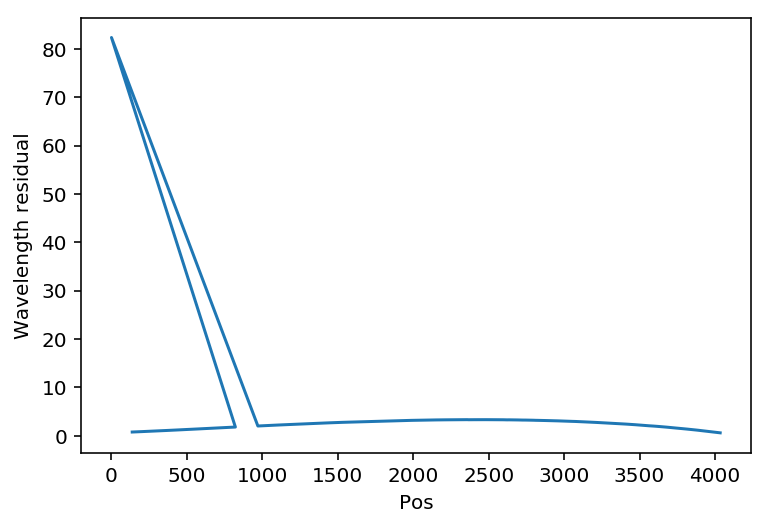

In [42]:
fiberId = 5
assert fiberId in data, "Unknown fiberId: %d" % fiberId
pixelPos = data[5]['pixelPos']
refWavelength = data[5]['refWavelength']
print(len(data))

#plt.plot(pixelPos,refWavelength)
plt.xlabel('Pos')


#linear wavelength solution
mod_wavelength=wavelength0 + nmPerPix*pixelPos
print(mod_wavelength)
print(data[5]['modelFitWavelength'])
#plt.plot(pixelPos,mod_wavelength)

plt.plot(pixelPos,refWavelength-mod_wavelength)
plt.ylabel('Wavelength residual')

Take a look at the statusFlags and the values of status from your fibre.  You probably want to ignore some of the data (Hint: I muttered about bad lines in the lecture)

In [32]:
print(statusFlags)
#note bit 32 is missing. The status values are sums of different status flags
print(len(pixelPos))
print(data[5]['status'])
print (len(data[5]['status']))

fit_mask=(data[5]['status']==1)
print (fit_mask)

{'FIT': 1, 'RESERVED': 2, 'SATURATED': 16, 'CR': 64, 'MISIDENTIFIED': 4, 'CLIPPED': 8}
54
[  1   1   1   1   1   1   1   1   1  49 112   1   1  49   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1]
54
[ True  True  True  True  True  True  True  True  True False False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


Text(0,0.5,'Wavelength residual')

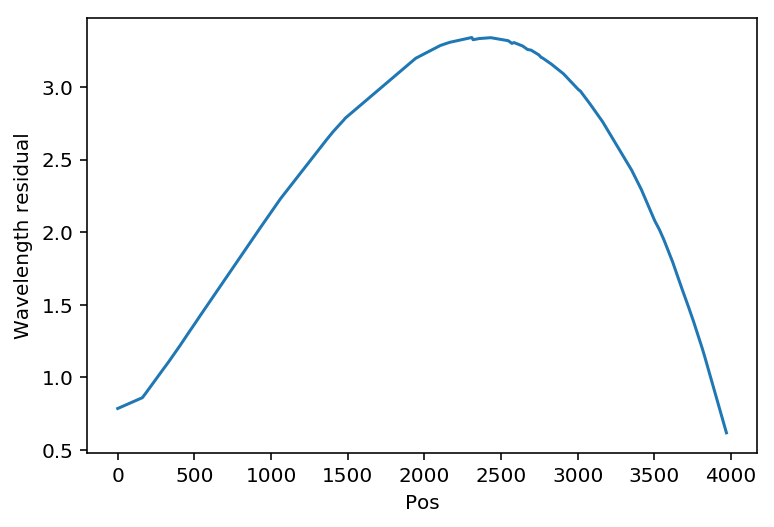

In [36]:
plt.plot(pixelPos[fit_mask],refWavelength[fit_mask]-mod_wavelength[fit_mask])
plt.xlabel('Pos')
plt.ylabel('Wavelength residual')

Let's concentrate on just one fiber for now; choose a fibre, any fibre.  We want to fit a better model of the wavelength solution.  The CCD has 4096 rows, and we want a solution valid over all of them.

Experiment with a range of order of fitter, and look at the rms error in the wavelength solution.  You can look at $\chi^2/\nu$ too, if you like, but I think you'll find that the centroiding errors are wrong.

You probably want to look at the fit and at the residuals from the fit.

[ 0  1  1  1  1  1  1  1  1  1 49  1  1 97  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


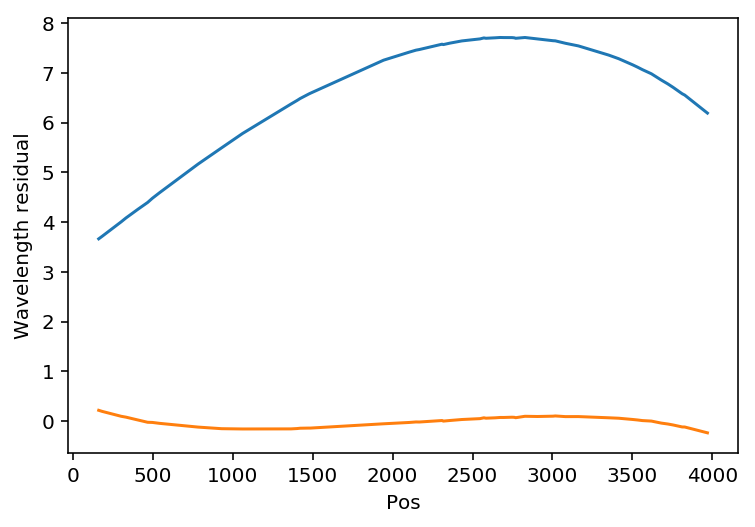

In [53]:
import numpy.polynomial.chebyshev
myFiberId = 315

nrow = 4096
fitOrder = 2

pixelPos_315 = data[myFiberId]['pixelPos']
refWavelength_315 = data[myFiberId]['refWavelength']

print(data[myFiberId]['status'])
fit_mask_315=(data[myFiberId]['status']==1)

pixelPos_315=pixelPos_315[fit_mask_315]
refWavelength_315=refWavelength_315[fit_mask_315]

mod_wavelength_315=wavelength0 + nmPerPix*pixelPos_315

plt.plot(pixelPos_315,refWavelength_315-mod_wavelength_315) #residuals linear fit
plt.xlabel('Pos')
plt.ylabel('Wavelength residual')

c=np.polynomial.chebyshev.chebfit(pixelPos_315,refWavelength_315,fitOrder)
mod_wavelength_315_cheb=np.polynomial.chebyshev.chebval(pixelPos_315,c)

plt.plot(pixelPos_315,refWavelength_315-mod_wavelength_315_cheb) #residuals cheb fit



Now repeat the preceeding exercise using the model of the spectrograph (i.e. the modelFitWavelength not your linear approximation).  What order of polynomial is needed now?

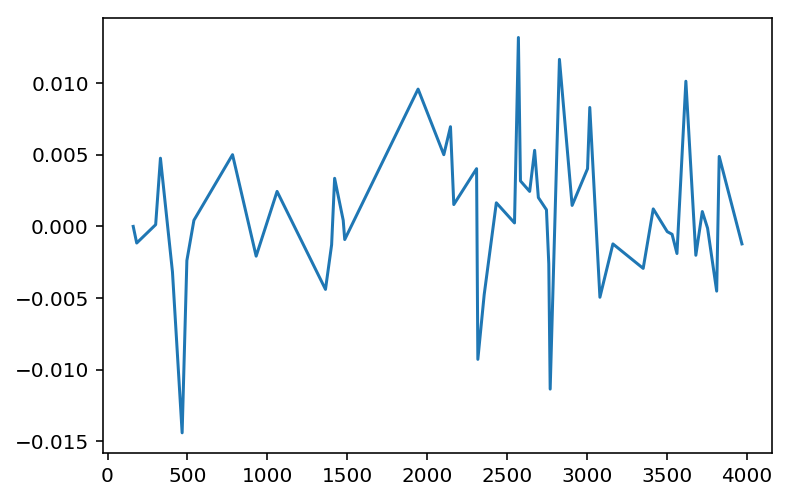

In [54]:
#modelFitWavelength
plt.plot(pixelPos_315,refWavelength_315-data[myFiberId]['modelFitWavelength'][fit_mask_315]) #residuals cheb fit

Is that rms error honest, or are we overfitting?  Modify your code to hold back some number of arclines from the fit and measure the rms only of those ones.

If this was all

I was nice and gave you clean (but real) data.  In the real world you'd probably want to do an n-sigma clip on the residuals and iterate.  Implement this.